금리가 오르면 기업은 돈을 갚음.(차라리 그게 이득)
따라서 진짜로 돈이 없어서 돈을 못값는 기업과 돈이 있는데 안갚는 기업을 구분하는게 목표

금리가 오르는 것을 기준으로
- dprime2 : 0=저금리, 1=고금리(10% 이상)
- MIS_Status : 채무불이행 여부 (0=채무이행, 1=채무불이행)


- 실수와 허수가 합쳐져있는 채무 불이행 ( dprime2 =0, MIS_Status = 1 )
- 허수만 있는 채무 불이행 ( dprime2 = 1, MIS_Status = 1 )
- 시계열 데이터가 아니라서 실제 실수를 파악 할 수 없음.

그 차이를 파악해보고자 함.

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
import pandas as pd
import os
import json

In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
df = pd.read_csv('/content/drive/MyDrive/비어플/금융투자/df_final3.csv')
print(df)
df_copy = df.copy()

        LoanNr_ChkDgt                            Name         City State  \
0          1000014003                  ABC HOBBYCRAFT   EVANSVILLE    IN   
1          1000935004                   Hairline Inc.    Vancouver    WA   
2          1003535008              Jason A. Philbrook     Rockland    ME   
3          1009994000          ARROW ENTERPRISE, INC.     BILLINGS    MT   
4          1011904005          ROBIN E. JONES, D.D.S.       TACOMA    WA   
...               ...                             ...          ...   ...   
864742     9022713002  BJORK, LAURA BEAUTY CONSULTANT    DALE CITY    VA   
864743     9035193000  PROFESSIONALS FOR NONPROFITS,I     NEW YORK    NY   
864744     9256453010            NORTHAIRE MARKET INC     SHAKOPEE    MN   
864745     9459933001            COMPUTER RENAISSANCE         CARY    NC   
864746     7377094002           NORTHLAND DATACOMM CO  MINNEAPOLIS    MN   

          Zip                           Bank BankState  NAICS ApprovalDate  \
0       4

In [54]:
# State, DisbursementDate, ChgOffDate2 변수를 제거한 DataFrame 생성
df = df.drop(['DisbursementDate', 'ChgOffDate2','LoanNr_ChkDgt','Name','City','Zip','Bank','BankState','ApprovalDate','ApprovalFY','Term','CreateJob','RetainedJob','ChgOffDate','DisbursementGross','ChgOffPrinGr','Year','Month','DATE','Density','Upper_Threshold','Lower_Threshold','Label'], axis=1)

# 처리된 DataFrame 확인
print(df.head())

  State  NAICS  NoEmp  NewExist  FranchiseCode  UrbanRural  LowDoc  \
0    IN     17      4         1              0           1       1   
1    WA     14      3         0              0           1       0   
2    ME     18      3         0              0           1       0   
3    MT      5     40         0              0           1       0   
4    WA      8      7         1              0           1       0   

   MIS_Status  GrAppv  SBA_Appv  ...  Recession  Term_re  smallmedium  \
0           0   60000     48000  ...          0        1            0   
1           0   10000      5000  ...          0        1            0   
2           0  127000     63500  ...          0        1            0   
3           0  400000    300000  ...          0        0            0   
4           0   75000     37500  ...          0        0            0   

   createjob2  retainedjob2  dis_re  appv_pct  DPRIME  dprime2  \
0           0             0       2      80.0    7.75        0   
1       

In [55]:
print(df.columns)

Index(['State', 'NAICS', 'NoEmp', 'NewExist', 'FranchiseCode', 'UrbanRural',
       'LowDoc', 'MIS_Status', 'GrAppv', 'SBA_Appv', 'SameState', 'Recession',
       'Term_re', 'smallmedium', 'createjob2', 'retainedjob2', 'dis_re',
       'appv_pct', 'DPRIME', 'dprime2', 'growth_potential'],
      dtype='object')


In [56]:
# 'dprime2'가 0인 경우의 개수
count_dprime2_0 = df[df['dprime2'] == 0].shape[0]

# 'dprime2'가 1인 경우의 개수
count_dprime2_1 = df[df['dprime2'] == 1].shape[0]

count_dprime2_0, count_dprime2_1

(850210, 14537)

## 채무 불이행으로 이루어진 새로운 데이터 프레임

In [57]:
# 'MIS_Status'가 0인 행만 선택하여 새로운 데이터프레임 생성
df_filtered = df[df['MIS_Status'] == 1]

In [60]:
print(df_filtered )

       State  NAICS  NoEmp  NewExist  FranchiseCode  UrbanRural  LowDoc  \
12        DE      2      1         0              0           1       0   
55        PA      1     24         1              0           0       0   
76        FL     13      6         0              1           0       0   
157       SC     14      2         1              0           1       0   
183       OK      2     40         0              0           1       0   
...      ...    ...    ...       ...            ...         ...     ...   
864639    NY     13      3         1              0           0       1   
864648    NJ     17      3         0              0           0       1   
864696    UT      5     11         1              0           1       0   
864699    NY     17      5         1              0           0       1   
864702    UT     10     32         0              0           1       0   

        MIS_Status  GrAppv  SBA_Appv  ...  Recession  Term_re  smallmedium  \
12               1   

In [61]:
print(df_filtered.columns)

Index(['State', 'NAICS', 'NoEmp', 'NewExist', 'FranchiseCode', 'UrbanRural',
       'LowDoc', 'MIS_Status', 'GrAppv', 'SBA_Appv', 'SameState', 'Recession',
       'Term_re', 'smallmedium', 'createjob2', 'retainedjob2', 'dis_re',
       'appv_pct', 'DPRIME', 'dprime2', 'growth_potential'],
      dtype='object')


### MIS_Status_2 변수 생성


- 실수와 허수가 합쳐져있는 채무 불이행 ( dprime2 =0, MIS_Status = 1 )  =  0
- 실수만 있는 채무 불이행 ( dprime2 = 1, MIS_Status = 1 )  =  1
- 진짜 돈이 없어서 못갚는 겨우를 확인하기 위해 생성 ->
이거 말고 실수와 허수를 더 분리 할 수 있는 파생변수는 없을까,,

In [62]:
# 'MIS_Status_2' 변수 생성 및 초기화
df_filtered['MIS_Status_2'] = 1

# 조건에 따라 값 변경
df_filtered.loc[(df_filtered['dprime2'] == 0) & (df_filtered['MIS_Status'] == 1), 'MIS_Status_2'] = 0
df_filtered.loc[(df_filtered['dprime2'] == 1) & (df_filtered['MIS_Status'] == 1), 'MIS_Status_2'] = 1

<ipython-input-62-f98261948dc3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['MIS_Status_2'] = 1


In [63]:
# 'MIS_Status_2'가 0일 때의 개수
count_0 = df_filtered[df_filtered['MIS_Status_2'] == 0].shape[0]

# 'MIS_Status_2'가 1일 때의 개수
count_1 = df_filtered[df_filtered['MIS_Status_2'] == 1].shape[0]

count_0, count_1

(147729, 991)

### 채무 불이행 EDA

#### (1) State

In [64]:
# 'MIS_Status_2' 값이 0인 State별 개수
count_0_by_state = df_filtered[df_filtered['MIS_Status_2'] == 0].groupby('State').size()

# 'MIS_Status_2' 값이 0인 State별 개수를 기준으로 내림차순 정렬하여 상위 10개 State 찾기
top_10_states_with_more_0 = count_0_by_state.nlargest(10)

top_10_states_with_more_0

State
CA    23160
TX    12133
NY    10984
FL    10964
IL     6226
GA     5091
PA     4841
OH     4827
NJ     4645
MI     4308
dtype: int64

In [65]:
# 'MIS_Status_2' 값이 1인 State별 개수
count_1_by_state = df_filtered[df_filtered['MIS_Status_2'] == 1].groupby('State').size()

# 'MIS_Status_2' 값이 1인 State별 개수를 기준으로 내림차순 정렬하여 상위 10개 State 찾기
top_10_states_with_more_1 = count_1_by_state.nlargest(10)

top_10_states_with_more_1

State
TX    121
CA     80
NY     74
MO     53
GA     49
VT     41
IL     37
KY     37
WI     33
KS     30
dtype: int64

In [66]:
# 각 State별로 'MIS_Status_2' 값이 0과 1인 개수 차이 계산
diff_by_state = abs(count_0_by_state - count_1_by_state)

# 차이가 적게 나는 상위 10개의 State 찾기
top_10_close_diff_states = diff_by_state.nsmallest(10)

top_10_close_diff_states

State
AK    150.0
SD    265.0
VT    291.0
ND    318.0
DC    369.0
WV    462.0
MT    478.0
HI    514.0
ME    527.0
NM    556.0
dtype: float64

-  Sate 변수 다시 살림.

- 거래 활발한곳 -> 불이행도 많음
하지만 초록색 확인. 거래에 비해 불이행률이 높은 상위 10개 지역임

소득세 포함 세금과 이행 불이행은 상관관계 X

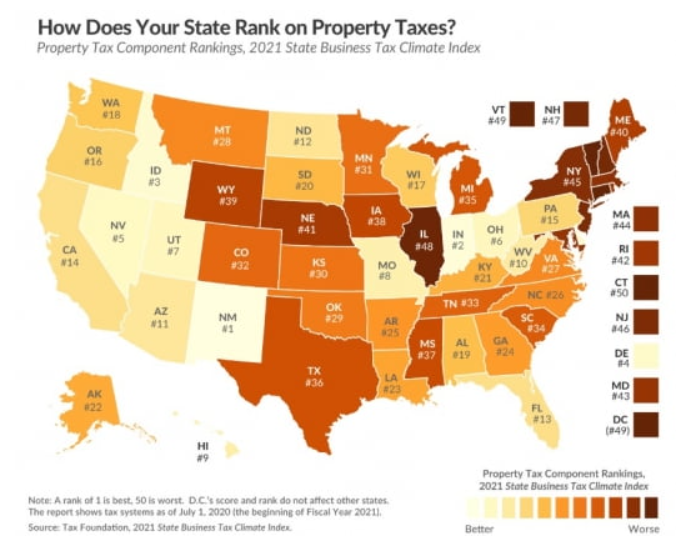

#### (2) NAICS

<ipython-input-67-441b9891eda8>:16: UserWarning: Glyph 49328 (\N{HANGUL SYLLABLE SAN}) missing from current font.
  plt.tight_layout()
<ipython-input-67-441b9891eda8>:16: UserWarning: Glyph 50629 (\N{HANGUL SYLLABLE EOB}) missing from current font.
  plt.tight_layout()
<ipython-input-67-441b9891eda8>:16: UserWarning: Glyph 44400 (\N{HANGUL SYLLABLE GUN}) missing from current font.
  plt.tight_layout()
<ipython-input-67-441b9891eda8>:16: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from current font.
  plt.tight_layout()
<ipython-input-67-441b9891eda8>:16: UserWarning: Glyph 50984 (\N{HANGUL SYLLABLE YUL}) missing from current font.
  plt.tight_layout()
<ipython-input-67-441b9891eda8>:16: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw

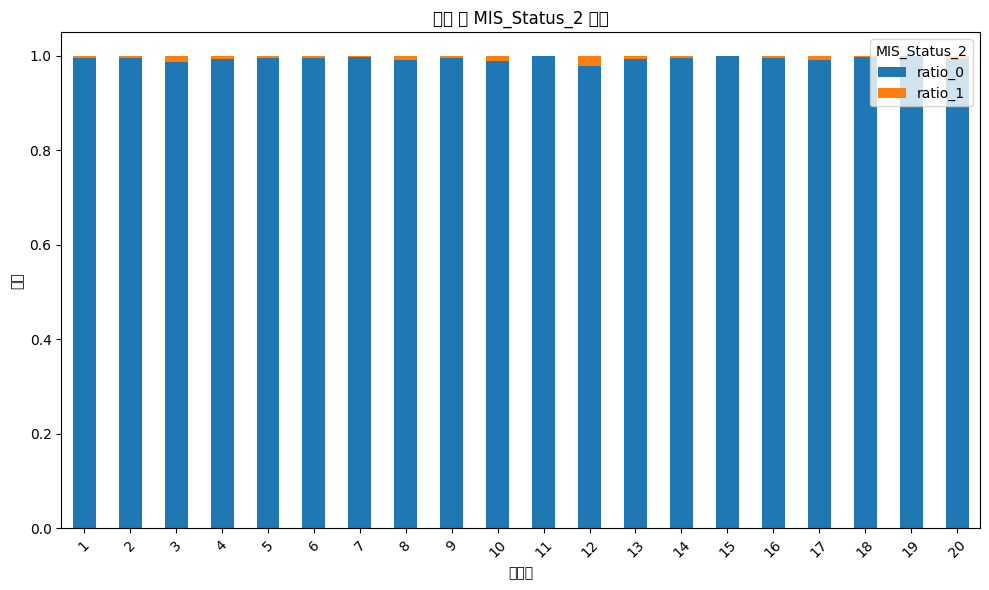

In [67]:
# NAICS 코드별 'MIS_Status_2' 값이 0과 1인 개수 구하기
count_by_naics = df_filtered.groupby('NAICS')['MIS_Status_2'].value_counts().unstack(fill_value=0)

# 각 NAICS 코드별로 'MIS_Status_2' 값의 비율 계산하기
count_by_naics['total'] = count_by_naics.sum(axis=1)
count_by_naics['ratio_0'] = count_by_naics[0] / count_by_naics['total']
count_by_naics['ratio_1'] = count_by_naics[1] / count_by_naics['total']

# 시각화
count_by_naics[['ratio_0', 'ratio_1']].plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('산업 별 MIS_Status_2 비율')
plt.xlabel('산업군')
plt.ylabel('비율')
plt.xticks(rotation=45)
plt.legend(title='MIS_Status_2', loc='upper right')
plt.tight_layout()
plt.show()

#### (3) NewExist

In [68]:
# 'NewExist' 값이 0일 때와 1일 때의 전체 행 수
total_count_NewExist_0 = len(df_filtered[df_filtered['NewExist'] == 0])
total_count_NewExist_1 = len(df_filtered[df_filtered['NewExist'] == 1])

# 'NewExist' 값이 0일 때와 1일 때의 'MIS_Status_2'가 1인 행의 개수
count_1_when_NewExist_0 = df_filtered[(df_filtered['NewExist'] == 0) & (df_filtered['MIS_Status_2'] == 1)].shape[0]
count_1_when_NewExist_1 = df_filtered[(df_filtered['NewExist'] == 1) & (df_filtered['MIS_Status_2'] == 1)].shape[0]

# 'MIS_Status_2'가 1인 비율 계산
ratio_1_when_NewExist_0 = count_1_when_NewExist_0 / total_count_NewExist_0 if total_count_NewExist_0 != 0 else 0
ratio_1_when_NewExist_1 = count_1_when_NewExist_1 / total_count_NewExist_1 if total_count_NewExist_1 != 0 else 0

ratio_1_when_NewExist_0, ratio_1_when_NewExist_1

(0.0063896848137535815, 0.007314856883234893)

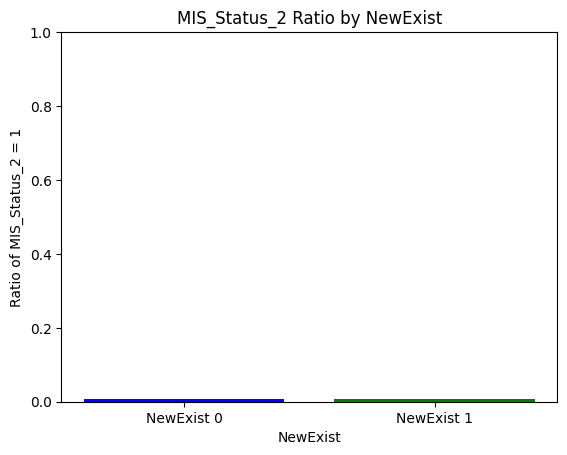

In [69]:
# 'NewExist' 값이 0일 때와 1일 때의 'MIS_Status_2'가 1인 비율
ratios = [ratio_1_when_NewExist_0, ratio_1_when_NewExist_1]

# 시각화
labels = ['NewExist 0', 'NewExist 1']
plt.bar(labels, ratios, color=['blue', 'green'])
plt.title('MIS_Status_2 Ratio by NewExist')
plt.xlabel('NewExist')
plt.ylabel('Ratio of MIS_Status_2 = 1')
plt.ylim(0, 1)  # y축 범위를 0부터 1까지로 설정하여 비율을 보기 쉽게 함
plt.show()

- 기존 비즈니스, 신규비즈니스 상관 없음.

#### (4) FranchiseCode

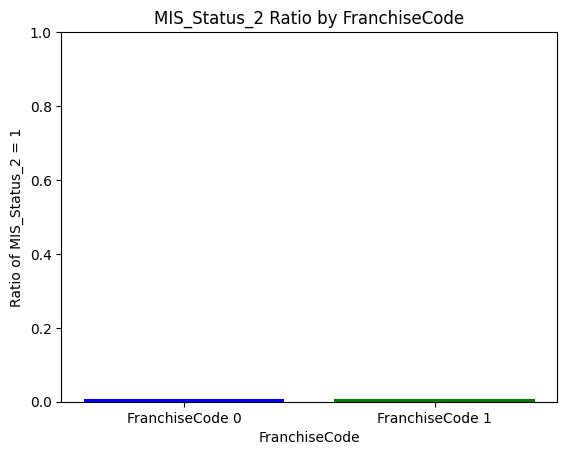

In [70]:
# 'FranchiseCode' 값이 0일 때와 1일 때의 'MIS_Status_2'가 1인 비율 계산
total_count_FranchiseCode_0 = len(df_filtered[df_filtered['FranchiseCode'] == 0])
total_count_FranchiseCode_1 = len(df_filtered[df_filtered['FranchiseCode'] == 1])

count_1_when_FranchiseCode_0 = df_filtered[(df_filtered['FranchiseCode'] == 0) & (df_filtered['MIS_Status_2'] == 1)].shape[0]
count_1_when_FranchiseCode_1 = df_filtered[(df_filtered['FranchiseCode'] == 1) & (df_filtered['MIS_Status_2'] == 1)].shape[0]

ratio_1_when_FranchiseCode_0 = count_1_when_FranchiseCode_0 / total_count_FranchiseCode_0 if total_count_FranchiseCode_0 != 0 else 0
ratio_1_when_FranchiseCode_1 = count_1_when_FranchiseCode_1 / total_count_FranchiseCode_1 if total_count_FranchiseCode_1 != 0 else 0

# 시각화
ratios = [ratio_1_when_FranchiseCode_0, ratio_1_when_FranchiseCode_1]
labels = ['FranchiseCode 0', 'FranchiseCode 1']
plt.bar(labels, ratios, color=['blue', 'green'])
plt.title('MIS_Status_2 Ratio by FranchiseCode')
plt.xlabel('FranchiseCode')
plt.ylabel('Ratio of MIS_Status_2 = 1')
plt.ylim(0, 1)
plt.show()

- 프렌차이즈 여부 상관 없음.

#### (5) UrbanRural

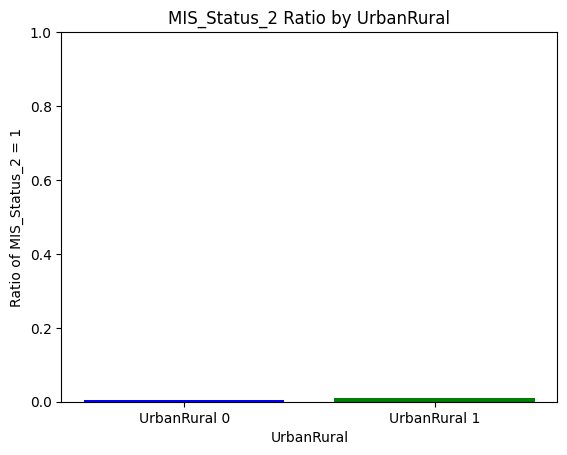

In [71]:
# 'UrbanRural' 값이 0일 때와 1일 때의 'MIS_Status_2'가 1인 비율 계산
total_count_UrbanRural_0 = len(df_filtered[df_filtered['UrbanRural'] == 0])
total_count_UrbanRural_1 = len(df_filtered[df_filtered['UrbanRural'] == 1])

count_1_when_UrbanRural_0 = df_filtered[(df_filtered['UrbanRural'] == 0) & (df_filtered['MIS_Status_2'] == 1)].shape[0]
count_1_when_UrbanRural_1 = df_filtered[(df_filtered['UrbanRural'] == 1) & (df_filtered['MIS_Status_2'] == 1)].shape[0]

ratio_1_when_UrbanRural_0 = count_1_when_UrbanRural_0 / total_count_UrbanRural_0 if total_count_UrbanRural_0 != 0 else 0
ratio_1_when_UrbanRural_1 = count_1_when_UrbanRural_1 / total_count_UrbanRural_1 if total_count_UrbanRural_1 != 0 else 0

# 시각화
ratios = [ratio_1_when_UrbanRural_0, ratio_1_when_UrbanRural_1]
labels = ['UrbanRural 0', 'UrbanRural 1']
plt.bar(labels, ratios, color=['blue', 'green'])
plt.title('MIS_Status_2 Ratio by UrbanRural')
plt.xlabel('UrbanRural')
plt.ylabel('Ratio of MIS_Status_2 = 1')
plt.ylim(0, 1)
plt.show()

- 차이 없음.

#### (6) LowDoc

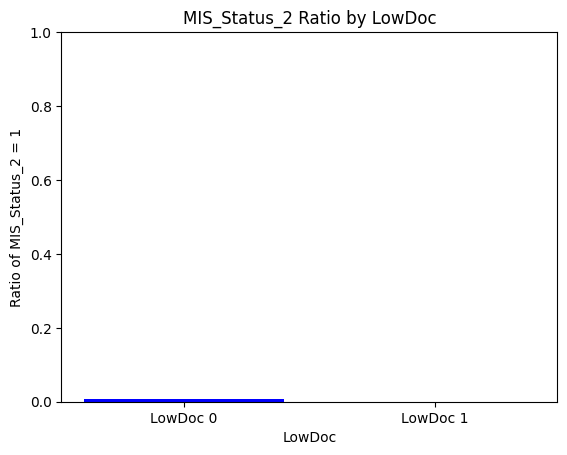

In [72]:
# 'LowDoc' 값이 0일 때와 1일 때의 'MIS_Status_2'가 1인 비율 계산
total_count_LowDoc_0 = len(df_filtered[df_filtered['LowDoc'] == 0])
total_count_LowDoc_1 = len(df_filtered[df_filtered['LowDoc'] == 1])

count_1_when_LowDoc_0 = df_filtered[(df_filtered['LowDoc'] == 0) & (df_filtered['MIS_Status_2'] == 1)].shape[0]
count_1_when_LowDoc_1 = df_filtered[(df_filtered['LowDoc'] == 1) & (df_filtered['MIS_Status_2'] == 1)].shape[0]

ratio_1_when_LowDoc_0 = count_1_when_LowDoc_0 / total_count_LowDoc_0 if total_count_LowDoc_0 != 0 else 0
ratio_1_when_LowDoc_1 = count_1_when_LowDoc_1 / total_count_LowDoc_1 if total_count_LowDoc_1 != 0 else 0

# 시각화
ratios = [ratio_1_when_LowDoc_0, ratio_1_when_LowDoc_1]
labels = ['LowDoc 0', 'LowDoc 1']
plt.bar(labels, ratios, color=['blue', 'green'])
plt.title('MIS_Status_2 Ratio by LowDoc')
plt.xlabel('LowDoc')
plt.ylabel('Ratio of MIS_Status_2 = 1')
plt.ylim(0, 1)
plt.show()

In [73]:
# 'LowDoc' 값이 0일 때와 1일 때의 'MIS_Status_2'가 1인 비율 계산
total_count_LowDoc_0 = len(df_filtered[df_filtered['LowDoc'] == 0])
total_count_LowDoc_1 = len(df_filtered[df_filtered['LowDoc'] == 1])

count_1_when_LowDoc_0 = df_filtered[(df_filtered['LowDoc'] == 0) & (df_filtered['MIS_Status_2'] == 1)].shape[0]
count_1_when_LowDoc_1 = df_filtered[(df_filtered['LowDoc'] == 1) & (df_filtered['MIS_Status_2'] == 1)].shape[0]

ratio_1_when_LowDoc_0 = count_1_when_LowDoc_0 / total_count_LowDoc_0 if total_count_LowDoc_0 != 0 else 0
ratio_1_when_LowDoc_1 = count_1_when_LowDoc_1 / total_count_LowDoc_1 if total_count_LowDoc_1 != 0 else 0

ratio_1_when_LowDoc_0, ratio_1_when_LowDoc_1

(0.007137044212224439, 0.0)

- SBA 신청을 안한 경우가 금리 기준으로  채무 불이행률이 더 높음.-> 큰차이 없음
  

#### (7) SameState

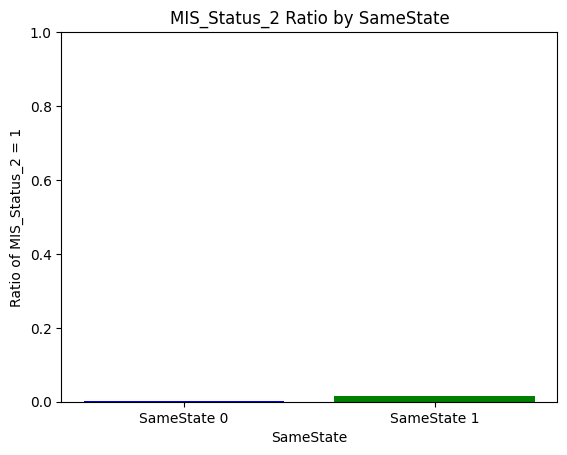

In [74]:
# 'SameState' 값이 0일 때와 1일 때의 'MIS_Status_2'가 1인 비율 계산
total_count_SameState_0 = len(df_filtered[df_filtered['SameState'] == 0])
total_count_SameState_1 = len(df_filtered[df_filtered['SameState'] == 1])

count_1_when_SameState_0 = df_filtered[(df_filtered['SameState'] == 0) & (df_filtered['MIS_Status_2'] == 1)].shape[0]
count_1_when_SameState_1 = df_filtered[(df_filtered['SameState'] == 1) & (df_filtered['MIS_Status_2'] == 1)].shape[0]

ratio_1_when_SameState_0 = count_1_when_SameState_0 / total_count_SameState_0 if total_count_SameState_0 != 0 else 0
ratio_1_when_SameState_1 = count_1_when_SameState_1 / total_count_SameState_1 if total_count_SameState_1 != 0 else 0

# 시각화
ratios = [ratio_1_when_SameState_0, ratio_1_when_SameState_1]
labels = ['SameState 0', 'SameState 1']
plt.bar(labels, ratios, color=['blue', 'green'])
plt.title('MIS_Status_2 Ratio by SameState')
plt.xlabel('SameState')
plt.ylabel('Ratio of MIS_Status_2 = 1')
plt.ylim(0, 1)
plt.show()

In [75]:
# 'SameState' 값이 0일 때와 1일 때의 'MIS_Status_2'가 1인 비율 계산
total_count_SameState_0 = len(df_filtered[df_filtered['SameState'] == 0])
total_count_SameState_1 = len(df_filtered[df_filtered['SameState'] == 1])

count_1_when_SameState_0 = df_filtered[(df_filtered['SameState'] == 0) & (df_filtered['MIS_Status_2'] == 1)].shape[0]
count_1_when_SameState_1 = df_filtered[(df_filtered['SameState'] == 1) & (df_filtered['MIS_Status_2'] == 1)].shape[0]

ratio_1_when_SameState_0 = count_1_when_SameState_0 / total_count_SameState_0 if total_count_SameState_0 != 0 else 0
ratio_1_when_SameState_1 = count_1_when_SameState_1 / total_count_SameState_1 if total_count_SameState_1 != 0 else 0

ratio_1_when_SameState_0, ratio_1_when_SameState_1

(0.003061567253706992, 0.015092644581695677)

- 같은 지역일 때 더 불이행이 더 높음

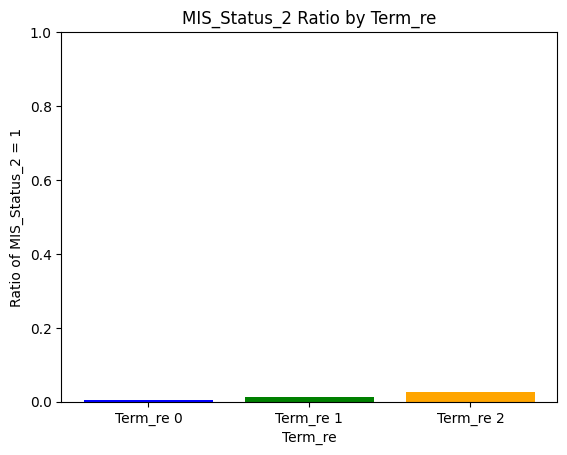

In [76]:
# Term_re 값이 0, 1, 2일 때의 'MIS_Status_2'가 1인 비율 계산
ratios = []
labels = []

for term_re_value in range(3):
    total_count = len(df_filtered[df_filtered['Term_re'] == term_re_value])
    count_1 = df_filtered[(df_filtered['Term_re'] == term_re_value) & (df_filtered['MIS_Status_2'] == 1)].shape[0]
    ratio_1 = count_1 / total_count if total_count != 0 else 0
    ratios.append(ratio_1)
    labels.append(f'Term_re {term_re_value}')

# 시각화
x = np.arange(len(labels))
plt.bar(x, ratios, color=['blue', 'green', 'orange'])
plt.title('MIS_Status_2 Ratio by Term_re')
plt.xlabel('Term_re')
plt.ylabel('Ratio of MIS_Status_2 = 1')
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.show()

In [77]:
# Term_re 값이 0, 1, 2일 때의 'MIS_Status_2'가 1인 비율 계산
ratios = []

for term_re_value in range(3):
    total_count = len(df_filtered[df_filtered['Term_re'] == term_re_value])
    count_1 = df_filtered[(df_filtered['Term_re'] == term_re_value) & (df_filtered['MIS_Status_2'] == 1)].shape[0]
    ratio_1 = count_1 / total_count if total_count != 0 else 0
    ratios.append(ratio_1)

ratios

[0.003439040720676852, 0.01142743468458512, 0.027528548123980423]

- 대출 기간이 길 떄, 정말 돈이 없어서 못갚는 불이행률이 높음

#### (9) smallmedium

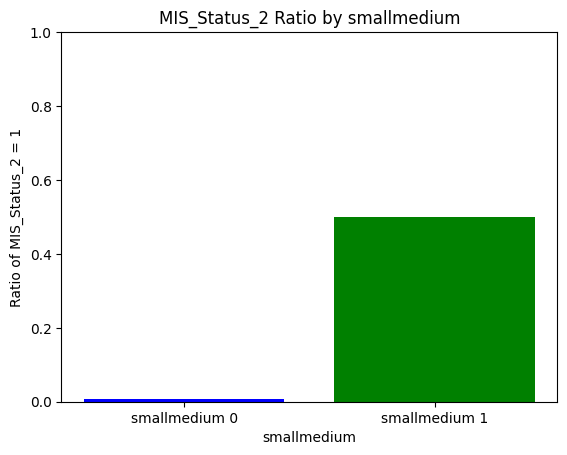

In [78]:
# smallmedium 값이 0, 1일 때의 'MIS_Status_2'가 1인 비율 계산
total_count_smallmedium_0 = len(df_filtered[df_filtered['smallmedium'] == 0])
total_count_smallmedium_1 = len(df_filtered[df_filtered['smallmedium'] == 1])

count_1_when_smallmedium_0 = df_filtered[(df_filtered['smallmedium'] == 0) & (df_filtered['MIS_Status_2'] == 1)].shape[0]
count_1_when_smallmedium_1 = df_filtered[(df_filtered['smallmedium'] == 1) & (df_filtered['MIS_Status_2'] == 1)].shape[0]

ratio_1_when_smallmedium_0 = count_1_when_smallmedium_0 / total_count_smallmedium_0 if total_count_smallmedium_0 != 0 else 0
ratio_1_when_smallmedium_1 = count_1_when_smallmedium_1 / total_count_smallmedium_1 if total_count_smallmedium_1 != 0 else 0

# 시각화
ratios = [ratio_1_when_smallmedium_0, ratio_1_when_smallmedium_1]
labels = ['smallmedium 0', 'smallmedium 1']
plt.bar(labels, ratios, color=['blue', 'green'])
plt.title('MIS_Status_2 Ratio by smallmedium')
plt.xlabel('smallmedium')
plt.ylabel('Ratio of MIS_Status_2 = 1')
plt.ylim(0, 1)
plt.show()

In [79]:
# smallmedium 값이 0일 때와 1일 때의 'MIS_Status_2'가 1인 비율 계산
total_count_smallmedium_0 = len(df_filtered[df_filtered['smallmedium'] == 0])
total_count_smallmedium_1 = len(df_filtered[df_filtered['smallmedium'] == 1])

count_1_when_smallmedium_0 = df_filtered[(df_filtered['smallmedium'] == 0) & (df_filtered['MIS_Status_2'] == 1)].shape[0]
count_1_when_smallmedium_1 = df_filtered[(df_filtered['smallmedium'] == 1) & (df_filtered['MIS_Status_2'] == 1)].shape[0]

ratio_1_when_smallmedium_0 = count_1_when_smallmedium_0 / total_count_smallmedium_0 if total_count_smallmedium_0 != 0 else 0
ratio_1_when_smallmedium_1 = count_1_when_smallmedium_1 / total_count_smallmedium_1 if total_count_smallmedium_1 != 0 else 0

ratio_1_when_smallmedium_0, ratio_1_when_smallmedium_1

(0.006650259555125205, 0.5)

- 고금리 -> 중기업이 불이행률이 더 높음
- 중기업(1)이 4개밖에 안됨,,,소기업(0)은 14만개....시각화하 비율로 보면 중기업은 다 돈이 없었던 것인데 일반화하긴 어렵,,,,버리기

#### (10) createjob2

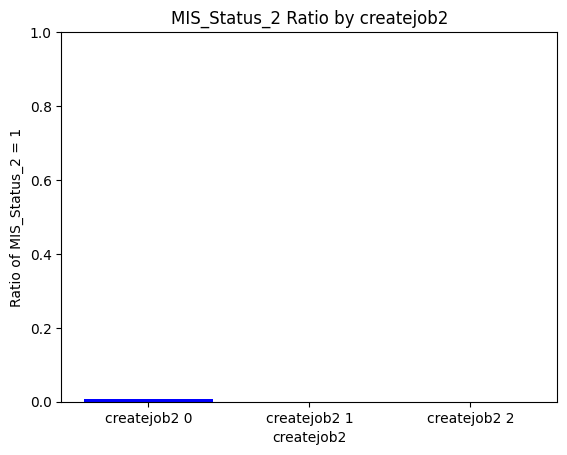

In [80]:
# createjob2 값이 0, 1, 2일 때의 'MIS_Status_2'가 1인 비율 계산
ratios = []
labels = []

for createjob2_value in range(3):
    total_count = len(df_filtered[df_filtered['createjob2'] == createjob2_value])
    count_1 = df_filtered[(df_filtered['createjob2'] == createjob2_value) & (df_filtered['MIS_Status_2'] == 1)].shape[0]
    ratio_1 = count_1 / total_count if total_count != 0 else 0
    ratios.append(ratio_1)
    labels.append(f'createjob2 {createjob2_value}')

# 시각화
x = np.arange(len(labels))
plt.bar(x, ratios, color=['blue', 'green', 'orange'])
plt.title('MIS_Status_2 Ratio by createjob2')
plt.xlabel('createjob2')
plt.ylabel('Ratio of MIS_Status_2 = 1')
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.show()

In [81]:
# createjob2 값이 0, 1, 2일 때의 'MIS_Status_2'가 1인 비율 계산
ratios = []

for createjob2_value in range(3):
    total_count = len(df_filtered[df_filtered['createjob2'] == createjob2_value])
    count_1 = df_filtered[(df_filtered['createjob2'] == createjob2_value) & (df_filtered['MIS_Status_2'] == 1)].shape[0]
    ratio_1 = count_1 / total_count if total_count != 0 else 0
    ratios.append(ratio_1)

ratios

[0.0075169719725414344, 0.0, 0.0]

- 돈이 정말로 없는 기업이면 신규 직원 못뽑지. 그렇게 나온듯

#### (11) retainedjob2

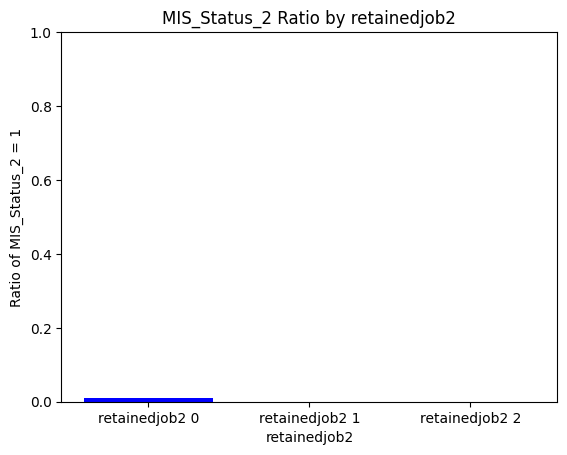

In [82]:
# retainedjob2 값이 0, 1, 2일 때의 'MIS_Status_2'가 1인 비율 계산
ratios = []
labels = []

for retainedjob2_value in range(3):
    total_count = len(df_filtered[df_filtered['retainedjob2'] == retainedjob2_value])
    count_1 = df_filtered[(df_filtered['retainedjob2'] == retainedjob2_value) & (df_filtered['MIS_Status_2'] == 1)].shape[0]
    ratio_1 = count_1 / total_count if total_count != 0 else 0
    ratios.append(ratio_1)
    labels.append(f'retainedjob2 {retainedjob2_value}')

# 시각화
x = np.arange(len(labels))
plt.bar(x, ratios, color=['blue', 'green', 'orange'])
plt.title('MIS_Status_2 Ratio by retainedjob2')
plt.xlabel('retainedjob2')
plt.ylabel('Ratio of MIS_Status_2 = 1')
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.show()

In [83]:
# retainedjob2 값이 0, 1, 2일 때의 'MIS_Status_2'가 1인 비율 계산
ratios = []

for retainedjob2_value in range(3):
    total_count = len(df_filtered[df_filtered['retainedjob2'] == retainedjob2_value])
    count_1 = df_filtered[(df_filtered['retainedjob2'] == retainedjob2_value) & (df_filtered['MIS_Status_2'] == 1)].shape[0]
    ratio_1 = count_1 / total_count if total_count != 0 else 0
    ratios.append(ratio_1)

ratios

[0.010276245385540669, 0.0, 0.0]

- 신규직원의 수와 마찬가지. 정말 돈이 없으니 신규 직원도 못뽑고 작은 기업인듯. 유지도 힘듦


#### (12) dis_re

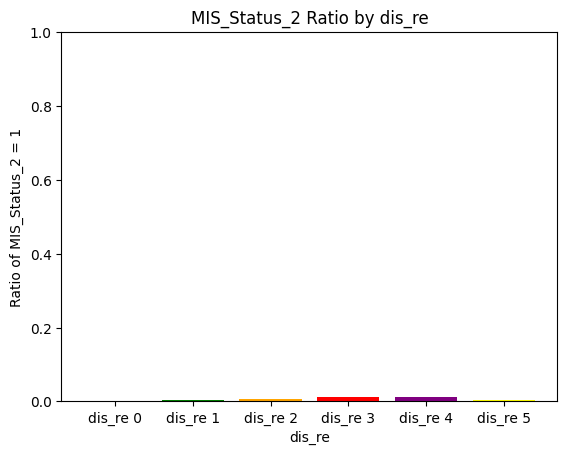

In [84]:
# dis_re 값이 0, 1, 2, 3, 4, 5일 때의 'MIS_Status_2'가 1인 비율 계산
ratios = []
labels = []

for dis_re_value in range(6):
    total_count = len(df_filtered[df_filtered['dis_re'] == dis_re_value])
    count_1 = df_filtered[(df_filtered['dis_re'] == dis_re_value) & (df_filtered['MIS_Status_2'] == 1)].shape[0]
    ratio_1 = count_1 / total_count if total_count != 0 else 0
    ratios.append(ratio_1)
    labels.append(f'dis_re {dis_re_value}')

# 시각화
x = np.arange(len(labels))
plt.bar(x, ratios, color=['blue', 'green', 'orange', 'red', 'purple', 'yellow'])
plt.title('MIS_Status_2 Ratio by dis_re')
plt.xlabel('dis_re')
plt.ylabel('Ratio of MIS_Status_2 = 1')
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.show()

In [85]:
# dis_re 값이 0, 1, 2, 3, 4, 5일 때의 'MIS_Status_2'가 1인 비율 계산
ratios = []

for dis_re_value in range(6):
    total_count = len(df_filtered[df_filtered['dis_re'] == dis_re_value])
    count_1 = df_filtered[(df_filtered['dis_re'] == dis_re_value) & (df_filtered['MIS_Status_2'] == 1)].shape[0]
    ratio_1 = count_1 / total_count if total_count != 0 else 0
    ratios.append(ratio_1)

ratios

[0.00013280212483399734,
 0.0030489004288130925,
 0.005728902981694157,
 0.011983103601600712,
 0.01307540748701415,
 0.0035398230088495575]

- 1억 ~ 3억을 빌린경우가 제일 돈 없는듯. 오히려 완전 적게나 많이 빌리면 허수.

#### (13) appv_pct

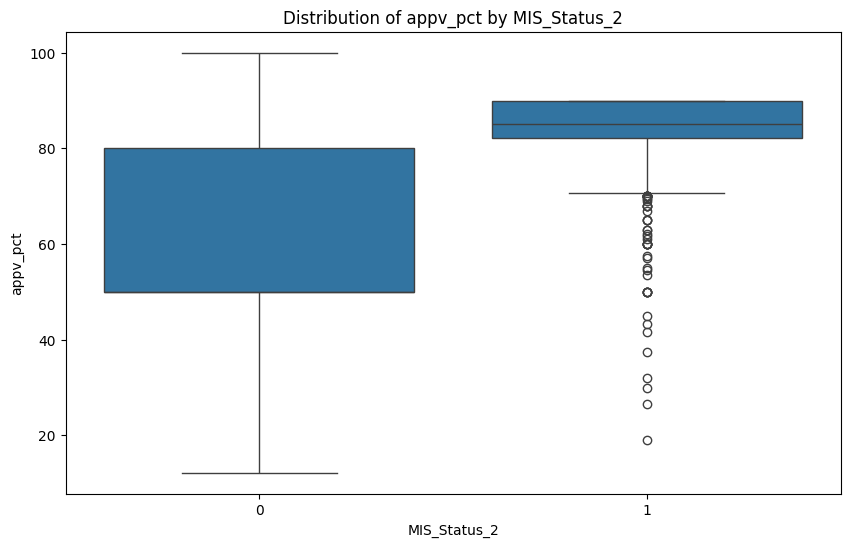

In [86]:
# MIS_Status_2가 0일 때와 1일 때의 appv_pct 분포를 비교하는 boxplot 그리기
plt.figure(figsize=(10, 6))
sns.boxplot(x='MIS_Status_2', y='appv_pct', data=df_filtered)
plt.title('Distribution of appv_pct by MIS_Status_2')
plt.xlabel('MIS_Status_2')
plt.ylabel('appv_pct')
plt.show()

- SBA는 소규모, 자산이 더 어려운 곳이 더 쉽게 융자를 받을 수 있음.
- SBA에서 보증해준 금액이 크다. = appv_pct


#### (14) growth_potential

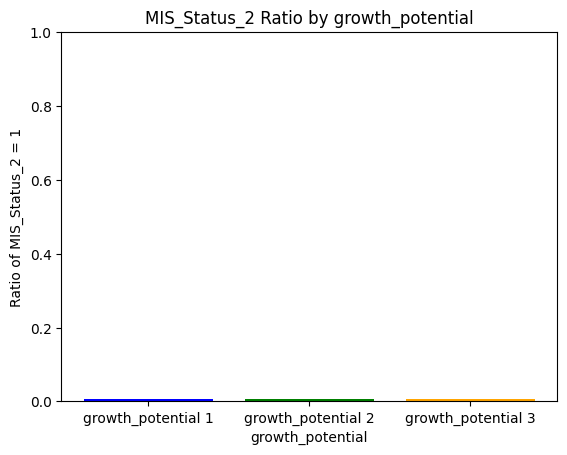

In [87]:
# growth_potential 값이 1, 2, 3일 때의 'MIS_Status_2'가 1인 비율 계산
ratios = []
labels = []

for growth_potential_value in range(1, 4):
    total_count = len(df_filtered[df_filtered['growth_potential'] == growth_potential_value])
    count_1 = df_filtered[(df_filtered['growth_potential'] == growth_potential_value) & (df_filtered['MIS_Status_2'] == 1)].shape[0]
    ratio_1 = count_1 / total_count if total_count != 0 else 0
    ratios.append(ratio_1)
    labels.append(f'growth_potential {growth_potential_value}')

# 시각화
x = np.arange(len(labels))
plt.bar(x, ratios, color=['blue', 'green', 'orange'])
plt.title('MIS_Status_2 Ratio by growth_potential')
plt.xlabel('growth_potential')
plt.ylabel('Ratio of MIS_Status_2 = 1')
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.show()

In [88]:
# growth_potential 값이 1, 2, 3일 때의 'MIS_Status_2'가 1인 비율 계산
ratios = []

for growth_potential_value in range(1, 4):
    total_count = len(df_filtered[df_filtered['growth_potential'] == growth_potential_value])
    count_1 = df_filtered[(df_filtered['growth_potential'] == growth_potential_value) & (df_filtered['MIS_Status_2'] == 1)].shape[0]
    ratio_1 = count_1 / total_count if total_count != 0 else 0
    ratios.append(ratio_1)

ratios

[0.007480003275913844, 0.005875073098421074, 0.005708354955889984]

- 차이 없음.

## 결론


지역의 소득 수준은 채무 이행능력과 관련이 없다.


- 해당 내용을 참고해 이자율이나 대출금을 산정하면 채무 불이행 예발에 도움이 될듯.